# 循環神經網絡 Recurrent Neural Networks
循環神經網絡解（RNN）特別適合處理序列的資料，序列資料代表資料的時間、前後順序有意義，例如文字資料，字詞的先後次序改變，可能意義就不一樣。 以前我們在處理文字資料時，把文件當成文字袋（Bag of Words）來處理，字詞出現的頻率成為觀察的重點，字詞的順序被忽略了，RNN則沒有這個毛病。


# 使用自己的資料
* 使用自己的中文的資料，有些地方要注意。
* 首先，tensorflow 有些工具可以讀入資料夾內的所有多檔案，並進行文字向量化的過程。所以資料的儲放方式與資料夾路徑要注意。資料可以是一筆一個檔案，也可能是放在一個大檔案中，一行代表一筆資料，有不同的指令處理這個問題。
* 原始的文字資料要向量化，改為以數字代表的序列，然而，在進行這個工作以前要斷詞，亦即以字詞為單位。當然斷詞的工具，中文與英文有別。
* 分析的過程，概分為:

 1 prepare data 資料前處理 

 2 model 建立模型

 3 compile

 4 fit

 5 evaluation

 6 application

 六個階段，在範例中都會說明。

* 本週我們介紹兩種資料匯入的方式，建立兩個模型 CNN 與 RNN。


In [5]:
# Be sure you're using the stable versions of both tf and tf-text, for binary compatibility.
!pip install -q -U tensorflow
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 8.3MB/s 



## 整理資料

In [6]:
import os
import shutil
import collections
import pathlib
import re
import string
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding,Bidirectional, Conv1D, GlobalMaxPooling1D,Dense,SimpleRNN
from tensorflow.keras import Sequential

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

### 叫入已斷詞之情緒文本

In [7]:
#####################################################################
import pandas as pd
path='d:/My python/'
df=pd.read_excel("https://ceiba.ntu.edu.tw/course/cd0f9d/sentiment_P_N_add_token.xlsx")
df

,Unnamed: 0,text,tag,token
0,0,(1)內存有點小。(2)附贈的鼠標太小了。(3)發現有的時候，在桌面上拖動鼠標，會有延遲的現...,N,內存 有點 小 。 附贈 的 鼠標 太小 了 。 發現 有 的 時候 ， 在 桌面上 拖動 ...
1,1,（1）外屏非彩屏，內屏的解析度128*160偏低。（2）內存小，處理器的速度慢。（3）圖像解...,N,外屏 非 彩屏 ， 內屏 的 解析度 * 偏低 。 內存 小 ， 處理器 的 速度慢 。 圖...
2,2,（1）我不知道在哪裡下載鈴聲，支持VK的網站實在少得可憐；（2）沒有簡訊卻群發功能，這對於我...,N,我 不 知道 在 哪裡 下載 鈴聲 ， 支持 VK 的 網站 實在 少得 可憐 ； 沒有 簡...
3,3,（1）按鍵不舒服，特別是處在邊緣的四個健13*越是中間的鍵越舒服。（2）製作上和國外大廠畢竟...,N,按鍵 不 舒服 ， 特別 是 處在 邊緣 的 四個 健 * 越是 中間 的 鍵 越 舒服 。...
4,4,（1）酒店冊子介紹說房間內提供飲用水，水壺內沒有水，給前臺提意見。前臺說飲用水就是衛生間的自...,N,酒店 冊子 介紹 說 房間內 提供 飲用水 ， 水壺 內 沒有 水 ， 給 前臺 提意見 。...
...,...,...,...,...
72935,72935,未來高雄將在半導體、電動車、綠能等各方面串起科技廊帶，加速下世代半導體產業發展，讓優秀人才不...,P,未來 高雄 將在 半導體 、 電動車 、 綠能 等 各 方面 串起 科技 廊 帶 ， 加速 ...
72936,72936,自己曾在外商公司服務，也將業界的精神、態度、語言帶市府，用最接地氣的方式服務產業界,P,自己 曾 在 外商 公司 服務 ， 也將 業界 的 精神 、 態度 、 語言 帶 市府 ， ...
72937,72937,非常重視產業轉型、創造就業兩大優先政策，未來市府在半導體供應鏈短鏈建構、解決五缺問題，串起上...,P,非常重視 產業轉型 、 創造 就業 兩大 優先 政策 ， 未來 市府 在 半導體 供應鏈 短...
72938,72938,結合亞灣5G AIoT創新園區的建設，將從產線到服務串起供應鏈，機會在高雄、歡迎大家踴躍投資,P,結合 亞灣 GAIoT 創新 園區 的 建設 ， 將從 產線 到 服務 串起 供應鏈 ， 機...


In [8]:
# 刪除 na
df.drop(list(df[df.token=="na"].index),axis=0, inplace=True)
len(df)

72940

In [9]:
df.tag.unique()

array(['N', 'P'], dtype=object)

In [10]:
# label 有錯誤校正
tag=df.tag.str.replace(" ","")
df.tag=tag

In [11]:
df.tag.unique()

array(['N', 'P'], dtype=object)

In [12]:
df.sample(10)

,Unnamed: 0,text,tag,token
9441,9441,今天讀了第八章——時間之箭，文中寫道未來，不僅僅是可能性，實際上是一種我們現在、此刻就擁有的...,P,今天 讀 了 第八章 — — 時間 之箭 ， 文中 寫道 未來 ， 不僅僅 是 可能性 ， ...
38882,38882,京東服務不用說了！蘋果太差了！不是第一次在京東買蘋果了！這次都是小的，沒一個圓的歪七歪八！還...,N,京東 服務 不用說 了 ！ 蘋果 太差 了 ！ 不是 第一次 在 京東 買 蘋果 了 ！ 這...
17787,17787,以前女兒就與鄰居家的小姐姐玩過「老狼老狼幾點鐘」的遊戲，這次見了故事書，喜歡得不得了。在幼兒...,P,以前 女兒 就 與 鄰居家 的 小姐姐 玩過 「 老狼 老狼 幾點鐘 」 的 遊戲 ， 這次...
16402,16402,簡單大方，配置不錯，但我是5399買的，看到有留言說4299就搶購到了，心裡覺得有一點點不平衡。,P,簡單 大方 ， 配置 不錯 ， 但 我 是 買 的 ， 看到 有留 言說 就 搶購 到 了 ...
52774,52774,褲子很不錯，摸著很舒服，質量特別好，洗了也不掉色。,P,褲子 很 不錯 ， 摸 著 很 舒服 ， 質量 特別 好 ， 洗 了 也 不 掉色 。
13848,13848,很久就聽說這書了，沒想到，不經意的閱讀後，帶給我的是淡淡的憂傷和惆悵。不知道童話也可以用平淡...,P,很久 就 聽說 這書 了 ， 沒想到 ， 不經意 的 閱讀 後 ， 帶給 我 的 是 淡淡的...
27044,27044,垃圾客服，打了十來個電話都沒解決得了！京東在這麼做，離關門不遠了,N,垃圾 客服 ， 打 了 十來個 電話 都 沒 解決 得 了 ！ 京東 在 這麼 做 ， 離 ...
16432,16432,"結合梁先生的<<初等數學復習及研究(平面幾何)>>,發現了這樣的一個問題現在市場上的中學生所...",P,"結合 梁先生 的 初等數學 復 習及 研究 平面幾何 , 發現 了 這樣 的 一個 問題 現..."
45411,45411,618活動買的，買了好多洗護系列，一大堆，可以全家四五口人用一年的了吧～京東師傅人很好，包裝...,P,活動 買 的 ， 買 了 好多 洗護 系列 ， 一大堆 ， 可以 全家 四五口 人用 一年 ...
69209,69209,一個字，屎，尤其前台和早餐的服務，絕對的差到極點,N,一個 字 ， 屎 ， 尤其 前臺 和 早餐 的 服務 ， 絕對 的 差 到極點


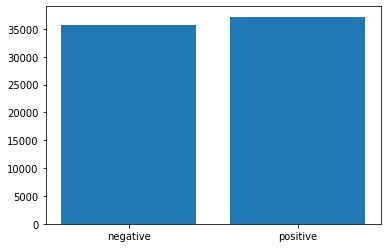

In [13]:
import matplotlib.pyplot as plt
classes = df.tag.unique()
counts = []

for i in classes:
  count = len(df[df.tag==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

## DataFrame 轉為檔案系統
sentiment_P_N_add_token.xlsx

## 檔案重組
* **一筆資料一個檔案**
* 檔案結構，須配合調整。
* 資料分 train 與test 兩個資料夾
* 其下依類別變數，分別存於不同的資料夾，資料夾名稱與類別變數同
* 本例有pos與neg兩個資料夾，代表不同的情感態度


* preprocessing.text_dataset_from_directory 函數可讀取檔案，其檔案的格式如下所示：
* 亦即我們要新建四個目錄，把所有的檔案拷貝進去。

dataset/train/pos/

......1.txt

......2.txt

dataset/train/neg/

......1.txt

......2.txt

dataset/test/pos/

......1.txt

......2.txt

dataset/test/neg/

......1.txt

......2.txt

### 區分為 df_train, df_test

In [14]:
df_test = pd.DataFrame()           
df_train = pd.DataFrame()          
tags = df['tag'].unique().tolist() 

# P 與 N 各抽百分之20 為 test 其餘為 train
for tag in tags:
    data = df[(df['tag'] == tag)]
    sample = data.sample(int(0.2*len(data)))
    sample_index = sample.index
    all_index = data.index
    residue_index = all_index.difference(sample_index) 
    residue = data.loc[residue_index]  
    df_test = pd.concat([df_test, sample], ignore_index=True)
    df_train = pd.concat([df_train, residue], ignore_index=True)
print(len(df_train))
print(len(df_test))     


58352
14588


In [15]:
# df_train 
df_train_P=df_train[(df_train.tag=="P")]["token"]
df_train_N=df_train[(df_train.tag=="N")]["token"]
# df_test
df_test_P=df_test[(df_test.tag=="P")]["token"]
df_test_N=df_test[(df_test.tag=="N")]["token"]

In [16]:
# 目前資料夾
cur=os.getcwd()
print (cur)

/content


In [17]:
# 產生資料夾
dir=["/dataset","/dataset/train","/dataset/test",
     "/dataset/train/positive","/dataset/train/negative",
     "/dataset/test/positive","/dataset/test/negative"]
for d in dir:
  if not os.path.exists(cur+d):
    os.mkdir(cur+d)
    print(cur+d + "已經建立！")
  else:
    shutil.rmtree(cur+d)
    os.mkdir(cur+d)
    print(cur+d + "已經建立！")

/content/dataset已經建立！
/content/dataset/train已經建立！
/content/dataset/test已經建立！
/content/dataset/train/positive已經建立！
/content/dataset/train/negative已經建立！
/content/dataset/test/positive已經建立！
/content/dataset/test/negative已經建立！


In [18]:
# 檢查資料
df_train_P

28616    我 是 月 日 入住 中遠 酒店 的 ， 我 覺得 的 價位 性價比 非常 高 , 酒店 可...
28617    外觀 時尚 ， 鍵盤 獨特 ， 色彩 亮麗 。 性價比 高 。 功能齊全 。 散熱 效果 非...
28618    這款 筆記本 外觀 感覺 挺 漂亮 的 ， 分量 嗎 ， 對 我 來說 不算 沉 。 安裝 ...
28619    京東 的 服務 還 可以 ， 但是 京東 配套 的 物流 就 真的 是 太差 了 ， 一般 ...
28620    性價比 不錯 ， 做工 精緻 ， 外觀 尚可 ， 很 適合 工科 生用 這個 配置 和 價位...
                               ...                        
58347        工研院 產科 國際 所長 蘇孟宗 表示 ， 工研院 以 孵化 國內 優質 企業 為 目標 
58348    未來 高雄 將在 半導體 、 電動車 、 綠能 等 各 方面 串起 科技 廊 帶 ， 加速 ...
58349    自己 曾 在 外商 公司 服務 ， 也將 業界 的 精神 、 態度 、 語言 帶 市府 ， ...
58350    非常重視 產業轉型 、 創造 就業 兩大 優先 政策 ， 未來 市府 在 半導體 供應鏈 短...
58351    結合 亞灣 GAIoT 創新 園區 的 建設 ， 將從 產線 到 服務 串起 供應鏈 ， 機...
Name: token, Length: 29736, dtype: object

### 重新整理資料夾與檔案

In [19]:
# 資料存入資料夾 "/dataset/train/positive/pos" 
for n in range(len(df_train_P)):
  with open(cur+"/dataset/train/positive/pos"+ str(n)+".txt","w") as f:
    try:
      f.write(df_train_P.tolist()[n]) 
    except:
      pass
# 資料存入資料夾 "/dataset/train/negative/neg"       
for n in range(len(df_train_N)):
  with open(cur+"/dataset/train/negative/neg"+ str(n)+".txt","w") as f:
    try:
      f.write(df_train_N.tolist()[n])
    except:
      pass  
# 資料存入資料夾 "/dataset/test/positive/pos"    
for n in range(len(df_test_P)):
  with open(cur+"/dataset/test/positive/pos"+ str(n)+".txt","w") as f:
    try:
       f.write(df_test_P.tolist()[n])
    except:
      pass       
# 資料存入資料夾 "/dataset/test/positive/pos"    
for n in range(len(df_test_N)):
  with open(cur+"/dataset/test/negative/neg"+ str(n)+".txt","w") as f:
    try:
       f.write(df_test_N.tolist()[n])
    except:
      pass

In [20]:
# 檢查檔案
test_positive=os.listdir(cur+"/dataset/test/positive")

In [21]:
# 讀取一個檔案檢查
import random
i=random.choice(test_positive)
file=open(cur+"/dataset/train/positive/"+i , mode='r')
file.read()

'性價比 不錯 ， 但是 就是 貨物 從 出庫 到 自 提點 速度 太慢 了 ， 我 月 日 下 的 單子 ， 到號 才 到 自 提點 '

## 1 讀入檔案，製作 batch
* text_dataset_from_directory（）
* raw_train_ds

In [22]:
# train_dir 為 train 資料夾的路徑
batch_size = 32
seed = 42
train_dir=cur+"/dataset/train"
raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 58352 files belonging to 2 classes.
Using 46682 files for training.


#### 印出檢查
* .take(1) 指令
* 中文要加 .decode("utf-8")

In [23]:
# 顯示資料，前十筆
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    # 注意要 .decode("utf-8") 才能顯示中文字，英文則不需要 ***
    print("doc: ", text_batch.numpy()[i].decode("utf-8"))
    print("Label:", label_batch.numpy()[i])

doc:  很差 ， 非常 小 很 不划算 ！ 不如 實體店 水果 ！ 謹慎 購買 ！ 
Label: 0
doc:  性價比 不錯 ， 鍵盤 比較 舒服 。 屏幕 的 現實 效果 很 好 ， 小巧 輕便 。 自帶 的 視頻 軟件 比較 好用 。 
Label: 1
doc:  我要 兩 條碼 的 ， 居然 搞錯 都 分不清 了 嗎 ， 瞎 幾把 發貨 ！ 
Label: 1
doc:  最不開心 的 一次 購物 ， 還 華為 京東 旗艦店 ， 去 店鋪 里 都 看到 了 什麼 ？ 食雜店 ， 什麼 破 玩意 ， 都 沒給 我 發票 ， 退貨 訛 我 * ， 氣人 ， 什麼 鬼 。 
Label: 0
doc:  信號 比較 差 ， 所以 導致 通話質量 不高 。 
Label: 0


In [24]:
# 顯示標籤(label)的代碼，共有兩個類別
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to negative
Label 1 corresponds to positive


In [25]:
# train 資料夾內的內容，取20%為 validation
raw_val_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 58352 files belonging to 2 classes.
Using 11670 files for validation.


In [26]:
# test 資料夾
test_dir = cur+"/dataset/test"
raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 14588 files belonging to 2 classes.


#### 亦即，我們現在有三個dataset，這是經過 batch 處理的
raw_train_ds, raw_validation_ds, raw_test_ds

## 2 文字向量化 textvectorization
* 每個字詞依其頻率給定編號，字詞（tokens）轉換為字詞編號的序列（integer mode）。
* 也可以文字袋的型式，將字詞向量化（binary mode），但失去了字詞的順序。我們以前者為例。
* 產生 train_ds, val_ds, test_ds 三個dataset

In [27]:
# 每篇文章最長的長度
MAX_SEQUENCE_LENGTH = 250
VOCAB_SIZE=10000
# 以 intergermode 文字向量化，設定文本長度最多 250
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [28]:
# 訓練組文字向量化, vectorize layer
train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [29]:
# 調整張量維度
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [30]:
# raw_train_ds 轉換為 dataset
train_ds = raw_train_ds.map(vectorize_text)

In [31]:
val_text = raw_val_ds.map(lambda text, labels: text)
vectorize_layer.adapt(val_text)
val_ds = raw_val_ds.map(vectorize_text)

In [32]:
test_text = raw_test_ds.map(lambda text, labels: text)
vectorize_layer.adapt(test_text)
test_ds = raw_test_ds.map(vectorize_text)

## 檢查轉換後的結果
* 從 raw_train_ds 讀取資料
* 第一個 batch, 第幾筆資料
* 印出原始文字，與向量化以後的dataset

In [33]:
# 第一個 batch，裡面的第一筆資料
text_batch, label_batch = next(iter(raw_train_ds))
check=10
check_doc, check_label = text_batch[check], label_batch[check]
# 印中文要加 .numpy().decode("utf-8")
print("doc:", check_doc.numpy().decode("utf-8"))
print("Label:", check_label.numpy())

doc: 面料 不錯 穿 上 很 舒服 大小 合適 
Label: 1


In [34]:
# 向量化以後的結果，與原始文字對照
# vectorize_text 是調整張量維度
check_vec=vectorize_text(check_doc, check_label)
# 同學可以自己測試 check_vec 的結構
print(check_vec)

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[549,  16, 154,  41,   8, 114, 255, 237,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
  

In [35]:
for n in range(15):
  c=check_vec[0].numpy()[0][n]
  print(c,"--", vectorize_layer.get_vocabulary()[c]) 
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

549 -- 面料
16 -- 不錯
154 -- 穿
41 -- 上
8 -- 很
114 -- 舒服
255 -- 大小
237 -- 合適
0 -- 
0 -- 
0 -- 
0 -- 
0 -- 
0 -- 
0 -- 
Vocabulary size: 10000


因為資料可能很龐大，檔案很多，有兩個方法可以避免匯入資料時卡住。
* .cache()讀入的資料會放在暫存區，這可避免訓練資料時讀取成為瓶頸。如果檔案很多特別有效。
* .prefetch() 訓練時資料處理與模型執行重疊(overlaps)的技巧，亦可提昇效率。


In [36]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
train_ds = configure_dataset(train_ds)
val_ds = configure_dataset(val_ds)
test_ds = configure_dataset(test_ds)

## 建立模型
* 已經建好向量化之後的三個 dataset
* int_train_ds, int_val_ds, int_test_ds


In [38]:
# 因為 padding 要補零
VOCAB_SIZE += 1

### CNN model

In [39]:
model_CNN = Sequential([
      Embedding(VOCAB_SIZE, 64, mask_zero=True),
      Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      GlobalMaxPooling1D(),
      Dense(2)
  ])
model_CNN.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640064    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 660,738
Trainable params: 660,738
Non-trainable params: 0
_________________________________________________________________


In [40]:
# cnn model
history_CNN = model_CNN.fit(
    train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
1459/1459 [==============================] - 53s 15ms/step - loss: 0.2817 - accuracy: 0.8881 - val_loss: 0.2093 - val_accuracy: 0.9241
Epoch 2/5
1459/1459 [==============================] - 14s 9ms/step - loss: 0.1541 - accuracy: 0.9473 - val_loss: 0.2073 - val_accuracy: 0.9270
Epoch 3/5
1459/1459 [==============================] - 14s 9ms/step - loss: 0.0886 - accuracy: 0.9738 - val_loss: 0.2479 - val_accuracy: 0.9191
Epoch 4/5
1459/1459 [==============================] - 14s 9ms/step - loss: 0.0440 - accuracy: 0.9891 - val_loss: 0.2866 - val_accuracy: 0.9167
Epoch 5/5
1459/1459 [==============================] - 14s 10ms/step - loss: 0.0204 - accuracy: 0.9952 - val_loss: 0.3236 - val_accuracy: 0.9182


### RNN model

In [41]:
model_RNN = Sequential([
    Embedding(VOCAB_SIZE,output_dim=64,mask_zero=True),
    SimpleRNN(64),
    Dense(64, activation='relu'),
    Dense(2)
  ])

# compile
model_RNN.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
model_RNN.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640064    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 652,610
Trainable params: 652,610
Non-trainable params: 0
_________________________________________________________________


In [42]:
# rnn model
history_RNN = model_RNN.fit(
    train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
1459/1459 [==============================] - 482s 329ms/step - loss: 0.3278 - accuracy: 0.8668 - val_loss: 0.4232 - val_accuracy: 0.7943
Epoch 2/5
1459/1459 [==============================] - 483s 331ms/step - loss: 0.2335 - accuracy: 0.9131 - val_loss: 0.2718 - val_accuracy: 0.9018
Epoch 3/5
1459/1459 [==============================] - 482s 330ms/step - loss: 0.1780 - accuracy: 0.9366 - val_loss: 0.2850 - val_accuracy: 0.9010
Epoch 4/5
1459/1459 [==============================] - 480s 329ms/step - loss: 0.1307 - accuracy: 0.9546 - val_loss: 0.3245 - val_accuracy: 0.8993
Epoch 5/5
1459/1459 [==============================] - 478s 328ms/step - loss: 0.0892 - accuracy: 0.9696 - val_loss: 0.3690 - val_accuracy: 0.8979


## 評估 test_ds

In [43]:
# 注意 資料集的格式 int_test_ds 
CNN_loss, CNN_accuracy = model_CNN.evaluate(test_ds)
RNN_loss, RNN_accuracy = model_RNN.evaluate(test_ds)

print("CNN model accuracy: {:2.2%}".format(CNN_accuracy))
print("RNN model accuracy: {:2.2%}".format(RNN_accuracy))

456/456 [==============================] - 12s 27ms/step - loss: 0.3423 - accuracy: 0.9017
CNN model accuracy: 92.12%
RNN model accuracy: 90.17%


## Export the model and predict

還記得，當初我們將資料分為 raw_train_da, raw_valid_ds, raw_test_ds 三個組。
這是還沒有encode的原始檔。如果要針對原始檔進行預測，我們要在模型中增加一個 'TextVectorization` layer. 一般的做法是產生一個新的model, 但是權數與你剛才訓練的模型一樣，這叫 Export the model.

In [44]:
# 先顯示 raw_test_ds 資料，前十筆
for text_batch, label_batch in raw_test_ds.take(1):
  for i in range(10):
    # 注意要 .decode("utf-8") 才能顯示中文字，英文則不需要 ***
    print("doc: ", text_batch.numpy()[i].decode("utf-8"))
    print("Label:", label_batch.numpy()[i])

doc:  不爽 ， 沒 贈品 。 。 。 。 。 。 。 。 。 
Label: 0
doc:  從 上海 出發 ， 滬杭 高速 ， 杭州 繞城 北線 ， 西線 ， 杭徽 高速 ， 臨安 出口 下 ， 右 轉彎 後 第一個 紅綠燈 加油站 左轉 ， 市標 轉盤 處有 一條 小馬路 直走 就 到 了 。 環境 很 好 ， 度假 的 好去處 。 
Label: 1
doc:  東西 感覺 一般 快遞 也 慢 沒 感覺 出 這家 店 東西 多好 
Label: 0
doc:  先天下之憂而憂 ” - - - - 是 這群 有 思想 、 有 大局觀 的 有識之士 的 共同 特徵 、 以 天下興亡 為 己任 ” - - - - 是 他們 的 高尚 品德 。 這樣 的 群體 越 壯大 ， 我們 的 國家 、 我們 的 民族 才 越 有 希望 。 希望 此書 能 喚醒 一部分 國人 ， 不要 再 沉迷於 娛樂 ” 、 網游 ” 之中 。 國家興亡 ， 匹夫有責 ， 國家 的 命運 承載 著 我們 共同 的 命運 ， 可 千萬 當打 醬油 ” 的 。 此書 章節 劃分 凌亂 ， 拼湊 感強 ， 喜歡 華麗 辭藻 、 講究 行文 的 朋友 - - - - 閃 。 
Label: 1
doc:  還 不錯 ， 快遞 速度 可以 。 蘋果 大小 比較 均勻 ， 重量 相差 不大 ， 我稱 了 一個 ， 克 。 
Label: 1
doc:  在 京東 買 了 很多 水果 ， 蘋果 ， 奇異果 很 好 ， 都 很 好吃 很 實惠 ， 比 實體店 便宜 多 了 ， 隔天 到 送貨 速度 也 非常 快 ， 吃 完 繼續 買 ， 也 是 佳節 送禮 的 好 佳品 喔 
Label: 1
doc:  用 了 不到 兩個 月 就 不能 開機 了 什麼 鬼 機器 還 自營 
Label: 0
doc:  太老舊 了 這個 酒店 潮濕味重 設施 舊 彷彿 九十年代 的 產物 
Label: 0
doc:  褲子 太長 而且 褲腳 有點 大 
Label: 0
doc:  很 值得 推薦 的 一 本書 ， 最初 是 買給 女兒 的 ， 同事 看到 後 覺得 不錯 ， 要 我 替 他們 買過 多次 。 
Label: 1


### export_model_CNN

In [45]:
# export_model_CNN
export_model_CNN = Sequential(
    [vectorize_layer, model_CNN,
     layers.Activation('sigmoid')])

# compile
export_model_CNN.compile(
    # 因為指定用 sigmoid, 所以 from_logits=False
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# 直接預測原始，未經向量化的 資料集 raw_test_ds
loss, accuracy = export_model_CNN.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(CNN_accuracy))

456/456 [==============================] - 4s 8ms/step - loss: 0.3225 - accuracy: 0.9212
Accuracy: 92.12%


### export_model_RNN

In [46]:
export_model_RNN = Sequential(
    [vectorize_layer, model_RNN,
     layers.Activation('sigmoid')])

export_model_RNN.compile(
    # 因為指定用 sigmoid, 所以 from_logits=False
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# 直接預測原始，未經向量化的 資料集 raw_test_ds
loss, accuracy = export_model_RNN.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(RNN_accuracy))

456/456 [==============================] - 15s 32ms/step - loss: 0.3423 - accuracy: 0.9017
Accuracy: 90.17%


直接輸入句子(已斷詞)，進行預測

In [47]:
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
  return predicted_labels

In [72]:
inputs = [
    "基本 上 壽司郎 還是 有 它 非常 的 高 標準 ，即使 之前 發生 了 衛生 管理 的 問題 ，但是 整體 來說 我 還是 覺得 它 非常 的 不錯",  
    "炸 南瓜 除了 沒有 南瓜 香甜 的 味道 ，麵衣 相當 的 油膩 。", 
    "經過 這次 之後 ，公館 壽司郎 變成 免費 送 我 才 想吃 的 餐廳",
    "菜 慢 飯 鬆 蝦 冰 魚 小 候位 久",
    "集點卡 的 集點 制度 有點 荒謬 ，居然 是 一人 一張 集點卡 ，不能 合併 使用",
    "食物 本身 都 是 好吃 的 ，拉麵 也 非常 可口 ，唯獨 壽司郎 的 醬料 口味 都 很重 很鹹",
    "鮭魚 果然 還是 要 季節 限定 才 好吃 啊",
    "週五 晚餐 時段 前往 ，非常 多 人",
    "榮登 愛店 之一 ，不過 假日 跟 連假 期間 最好 不要 去 ，以免 等 太久",
    "只能 說 這裡 的 餐具 都 非常 的 髒",

    "超級 不 推薦 蛤蜊 湯 覺得 食材 沒有 很 新鮮",
    "系統 時間 有 問題 你 要 先 講",
    "推薦 濃 海膽 麵 ，有 加 紫蘇 ，不愛 的 不要 點",
    "服務生 說話 超級 快 很 像 複讀 機器",
    "到底 哪個 天才 設計 的 定位 服務 啊 ，爛 死 了 ，欺騙 消費者 很 可惡",
    "不會 想 來 這家 光顧 了",
    "一間 連鎖 日本 評選 為 第一名 的 迴轉 壽司 不 應該 有 這種 失誤 吧",
    "覺得 食材 都 縮水 了 厚度 也 比 以前 薄",
    "懷疑 是 不是 座位 太 偏僻 ，好 食物 都 被 拿走 了",
    "服務 人員 聚集 聊天 真 虧 了 鲑魚 的 行銷",
   
]
predicted_scores = export_model_RNN.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
  print("句子: ", input)
  print("預測: ", label.numpy())

句子:  基本 上 壽司郎 還是 有 它 非常 的 高 標準 ，即使 之前 發生 了 衛生 管理 的 問題 ，但是 整體 來說 我 還是 覺得 它 非常 的 不錯
預測:  b'positive'
句子:  炸 南瓜 除了 沒有 南瓜 香甜 的 味道 ，麵衣 相當 的 油膩 。
預測:  b'positive'
句子:  經過 這次 之後 ，公館 壽司郎 變成 免費 送 我 才 想吃 的 餐廳
預測:  b'negative'
句子:  菜 慢 飯 鬆 蝦 冰 魚 小 候位 久
預測:  b'negative'
句子:  集點卡 的 集點 制度 有點 荒謬 ，居然 是 一人 一張 集點卡 ，不能 合併 使用
預測:  b'positive'
句子:  食物 本身 都 是 好吃 的 ，拉麵 也 非常 可口 ，唯獨 壽司郎 的 醬料 口味 都 很重 很鹹
預測:  b'positive'
句子:  鮭魚 果然 還是 要 季節 限定 才 好吃 啊
預測:  b'positive'
句子:  週五 晚餐 時段 前往 ，非常 多 人
預測:  b'positive'
句子:  榮登 愛店 之一 ，不過 假日 跟 連假 期間 最好 不要 去 ，以免 等 太久
預測:  b'negative'
句子:  只能 說 這裡 的 餐具 都 非常 的 髒
預測:  b'negative'
句子:  超級 不 推薦 蛤蜊 湯 覺得 食材 沒有 很 新鮮
預測:  b'positive'
句子:  系統 時間 有 問題 你 要 先 講
預測:  b'positive'
句子:  推薦 濃 海膽 麵 ，有 加 紫蘇 ，不愛 的 不要 點
預測:  b'positive'
句子:  服務生 說話 超級 快 很 像 複讀 機器
預測:  b'positive'
句子:  到底 哪個 天才 設計 的 定位 服務 啊 ，爛 死 了 ，欺騙 消費者 很 可惡
預測:  b'negative'
句子:  不會 想 來 這家 光顧 了
預測:  b'negative'
句子:  一間 連鎖 日本 評選 為 第一名 的 迴轉 壽司 不 應該 有 這種 失誤 吧
預測:  b'negative'
句子:  覺得 食材 都 縮水 了 厚度 也 比 以前 薄
預測:  b'positive'
句子:  懷疑 是 不